# Index
* [Import](#index)
* [Tokenization](#Tokenization)
* [CountVectorizer](#CountVectorizer)
* [PreprocessPipeline](#PreprocessPipeline)
* [OvsRest](#OvsRest)
    - [LogisticRegression](#LogisticRegression)
    - [SVC](#SVC)
* [Word2Vec](#Word2Vec)
* [BERT](#BERT)
* [USE](#USE)
* [LDA](#LDA)

In [1]:
import time
import json
import os

# from joblib import dump, load, Memory
import joblib
import dill
import weakref

# import warnings

import numpy as np
import pandas as pd
import gensim
import pyLDAvis
import matplotlib.pyplot as plt

# from gensim import (
#     corpora,
# )  # https://pypi.org/project/gensim/ #https://radimrehurek.com/gensim/auto_examples/core/run_topics_and_transformations.html#sphx-glr-auto-examples-core-run-topics-and-transformations-py
from sklearn import (
    metrics,
    feature_extraction,
    linear_model,
    model_selection,
    preprocessing,
    cluster,
    decomposition,
    multiclass,
    svm,
    pipeline,
    exceptions,
    manifold,
)
from wordcloud import WordCloud
from sklearn.utils._testing import ignore_warnings
from sklearn.base import BaseEstimator, TransformerMixin
import tensorflow as tf
import tensorflow_hub as hub
from transformers import (
    AutoTokenizer,
    TFAutoModel,
    AutoModel,
    BertTokenizer,
    TFBertModel,
    BertConfig,
)  # BertModel
import transformers
from tokenizers import BertWordPieceTokenizer


# import nlpk

/opt/conda/lib/python3.7/site-packages/past/types/oldstr.py:36: DeprecationWarning: invalid escape sequence \d
  """
/opt/conda/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:585: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.object,
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:627: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Dep

In [2]:
from kerasembedtransformerclass import p5_nlp_utils

https://scikit-learn.org/stable/modules/multiclass.html test autre stategie que OneVsRest  
https://keras.io/examples/nlp/text_extraction_with_bert/  

In [3]:
pip install -q jupyter-black jupyter

Note: you may need to restart the kernel to use updated packages.


In [4]:
# for black formating
import jupyter_black  # pip install jupyter-black jupyter

jupyter_black.load()
# ??jupyter_black.load #show config

In [5]:
df = pd.read_csv(
    "/kaggle/input/p5-nlp/stackoverflowCleaned.csv", index_col=0, low_memory=False
)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118442 entries, 0 to 118441
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Id           118442 non-null  int64 
 1   Title        118442 non-null  object
 2   Body         118442 non-null  object
 3   0            118440 non-null  object
 4   1            118383 non-null  object
 5   2            118292 non-null  object
 6   3            118292 non-null  object
 7   4            76389 non-null   object
 8   5            4 non-null       object
 9   Title_clean  118389 non-null  object
 10  Code         88202 non-null   object
 11  Body_clean   118392 non-null  object
dtypes: int64(1), object(11)
memory usage: 11.7+ MB


In [6]:
LONG = False
description = {
    "title": "USE avec recherche best limit , epochs 100 et visu tsne",
    "CountVectorizer": {"min_df": 0.00001, "max_df": 0.995, "max_features": None},
    "StandardScaler": {"actif": False},
    "TruncatedSVD": {"actif": False, "n_components": 1_000},
    "LogisticRegression": {"actif": False},
    "TfidfOvRSVC": {"actif": False, "max_iter": 100},
    "kerasPipeline": {
        "actif": False,
        "TextVectorization__max_tokens": 210_000,  # 20_000,
        "TextVectorization__output_sequence_length": 100,  # 20
        "Embedding__output_dim": 500,
        "Word2Vec__min_count": 5,
        "Word2Vec__window": 25,
        "Word2Vec__epochs": 150,  # 100,
        "fit__epochs": 15,  # 15
    },
    "Word2Vec": {
        "actif": False,
        "min_count": 1,
        "size": 500,
        "window": 10,
        "epochs": 100,
        "maxlen": 50,
        "max_iter": 6_000,
    },
    "BERT": {
        "actif": False,
        "max_length": 512,
        "epochs": 5,
    },
    "USE": {"actif": True, "tsne_visu": False, "epochs": 300},
    "LDA": {
        "actif": False,
        "num_topics": [20],  # [5, 10, 20],
        "lda__no_below": 100,
        "lda__no_above": 0.5,
        "lda__max_tokens": 100_000,
        "lda__iterations": 50,
        "word_cloud__nb_words": 50,
    },
}

In [7]:
# # ultra fast
# description["kerasPipeline"]["fit__epochs"] = 1
# description["kerasPipeline"]["TextVectorization__max_tokens"] = 100
# description["kerasPipeline"]["TextVectorization__output_sequence_length"] = 5
# description["kerasPipeline"]["Word2Vec__epochs"] = 1
# description["kerasPipeline"]["Embedding__output_dim"] = 10

In [8]:
class colors:
    PURPLE = "\033[95m"
    BLUE = "\033[94m"
    CYAN = "\033[96m"
    GREEN = "\033[92m"
    YELLOW = "\033[93m"
    RED = "\033[91m"
    ENDC = "\033[0m"
    BOLD = "\033[1m"
    UNDERLINE = "\033[4m"

# Tokenization

In [9]:
from ipywidgets import interact


@interact(i=(0, df.shape[0] - 1))
def test_tr_print(i):
    print(
        f'Title:{df["Title"][i]}\n{"*"*30}\nTitle_clean:{df["Title_clean"][i]}\n{"*"*30}\nBody:{df["Body"][i]}\n{"*"*30}\nBody_clean:{df["Body_clean"][i]}\n{"*"*30}\nCode:{df["Code"][i]}\n{"*"*30}\nTags:{df.loc[i,"0"]} {df.loc[i,"1"]} {df.loc[i,"2"]} {df.loc[i,"3"]} {df.loc[i,"4"]}'
    )

/opt/conda/lib/python3.7/site-packages/ipykernel/pylab/backend_inline.py:13: DeprecationWarning: `ipykernel.pylab.backend_inline` is deprecated, directly use `matplotlib_inline.backend_inline`
  DeprecationWarning,


interactive(children=(IntSlider(value=59220, description='i', max=118441), Output()), _dom_classes=('widget-in…

In [10]:
print(sum(df["Title_clean"].isna()))
df[df["Title_clean"].isna()][
    ["Title", "Title_clean", "Body", "Body_clean", "0", "1", "2", "3", "4"]
].head(5)

53


,Title,Title_clean,Body,Body_clean,0,1,2,3,4
302,Is < faster than <=?,NaN,<p>Is <code>if (a &lt; 901)</code> faster than...,example performance change loop code suppose g...,c++,c,performance,assembly,relational-operators
393,What is setup.py?,NaN,<p>What is <code>setup.py</code> and how can i...,configure,python,pypi,setup.py,python-packaging,NaN
1437,What is related_name used for?,NaN,<p>What is the <code>related_name</code> argum...,argument manytomanyfield foreignkey field exam...,python,django,foreign-keys,many-to-many,NaN
4062,"What is ""android:allowBackup""?",NaN,"<p>Since the <a href=""http://tools.android.com...",adt preview version version lint warning tell ...,android,adt,compiler-warnings,android-lint,android-backup-service
4870,Why is 0 < -0x80000000?,NaN,<p>I have below a simple program:</p>\n\n<pre>...,program condition if(bal int32_min work change...,c,signed,numeric-limits,numeric-conversion,NaN


In [11]:
print(sum(df["Body_clean"].isna()))
df[df["Body_clean"].isna()][
    ["Title", "Title_clean", "Body", "Body_clean", "Code"]
].head(5)

50


,Title,Title_clean,Body,Body_clean,Code
5,What and where are the stack and heap?,stack heap,<ul>\n<li>What are the stack and heap?</li>\n<...,NaN,NaN
168,What is The Rule of Three?,rule,<ul>\n<li>What does <em>copying an object</em>...,NaN,NaN
828,Why are these constructs using pre and post-in...,construct pre behavior,<pre><code>#include &lt;stdio.h&gt;\n\nint mai...,NaN,#include <stdio.h>\n\nint main(void)\n{\n in...
1207,How to use ADB Shell when Multiple Devices are...,use adb shell multiple device connect fail err...,<pre><code>$ adb --help\n</code></pre>\n<hr />...,NaN,$ adb --help\n -s SERIAL use device with give...
1640,What are the advantages of list initialization...,advantage list initialization brace,<pre><code>MyClass a1 {a}; // clearer and ...,NaN,MyClass a1 {a}; // clearer and less error-...


In [12]:
len(df[df["Body_clean"].isna() & df["Title_clean"].isna()])

0

In [13]:
tags = df[["0", "1", "2", "3", "4", "5"]].stack()
target_names = [
    tag
    for tag, freq in tags.reset_index(drop=True).value_counts(normalize=True).items()
    if freq > 0.002
]
if not LONG:
    target_names = target_names[0:20] + ["git"]
print(f"taille {len(target_names)}\n{' '.join(target_names)}")

taille 21
java c# javascript python android c++ ios html php .net jquery css objective-c c sql iphone asp.net mysql linux node.js git


In [14]:
# Enregistrement des paramétres avec la liste des tags a predire
description["target_names"] = target_names
with open("/kaggle/working/description.json", "w") as outfile:
    json.dump(description, outfile)

In [15]:
p5_nlp_utils.Commun.tags_are_in(
    df[0:10], ["javascript", "java", "c#", "python", "html", "git", "php"]
)

,javascript,java,c#,python,html,git,php
0,False,True,False,False,False,False,False
1,False,False,False,False,False,True,False
2,False,False,False,False,False,True,False
3,False,False,False,False,False,True,False
4,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False
6,False,False,False,False,False,True,False
7,True,False,False,False,False,False,False
8,True,False,False,False,False,False,False
9,False,False,False,True,False,False,False


## Separation train/test

In [16]:
df["Token"] = df["Title_clean"].fillna("") + df["Body_clean"].fillna("")
print(
    f"{len(df[[len(token.split()) > 1 for token in df['Token']]])/len(df):.5%} des questions ont au moins 2tokens"
    if len(df[df["Token"] == ""]) == 0
    else f"{len(df[df['Token'] == ''])} questions n'ont pas de token"
)
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    df["Token"], p5_nlp_utils.Commun.tags_are_in(df, target_names), random_state=42
)

99.99409% des questions ont au moins 2tokens


## Nombre et % de chaque tag dans train et test
Une question peut avoir plusieur tag donc la somme est supérieur aux nombres de ligne

In [17]:
print("|tag positif  nb train   %    |  test   %   |")
for column in y_train.columns:
    nb_positif_train = y_train[y_train[column]].shape[0]
    nb_positif_test = y_test[y_test[column]].shape[0]
    print(
        f"|{colors.BOLD}{column: <14}{colors.ENDC}{colors.GREEN}{nb_positif_train: <8}{colors.ENDC}{(nb_positif_train/y_train.shape[0]):06.2%} | {colors.GREEN}{nb_positif_test:<5}{colors.ENDC} {nb_positif_test/y_test.shape[0]:06.2%}|"
    )

|tag positif  nb train   %    |  test   %   |
|java          10706   12.05% | 3558  12.02%|
|c#            10484   11.80% | 3473  11.73%|
|javascript    10451   11.77% | 3356  11.33%|
|python        7652    08.61% | 2612  08.82%|
|android       6216    07.00% | 2045  06.91%|
|c++           5893    06.63% | 1964  06.63%|
|ios           5554    06.25% | 1840  06.21%|
|html          5198    05.85% | 1755  05.93%|
|php           4935    05.56% | 1627  05.49%|
|.net          4746    05.34% | 1569  05.30%|
|jquery        4762    05.36% | 1538  05.19%|
|css           3350    03.77% | 1131  03.82%|
|objective-c   2736    03.08% | 888   03.00%|
|c             2734    03.08% | 885   02.99%|
|sql           2665    03.00% | 870   02.94%|
|iphone        2479    02.79% | 807   02.73%|
|asp.net       2424    02.73% | 805   02.72%|
|mysql         2107    02.37% | 685   02.31%|
|linux         2082    02.34% | 680   02.30%|
|node.js       2034    02.29% | 682   02.30%|
|git           840     00.95% | 27

### Regroupement des tags pour visualisation tsne:
En une collone unique pour représenter tout les tags dans 1graph, avec priorité pour les tags les moins fréquents  
Ici la somme = nombre de ligne  

In [18]:
%%time
y_train_monodim = pd.Series(index=y_train.index, dtype=bool)
for tag in y_train.columns:
    y_train_monodim = (
        y_train[tag]
        .replace(to_replace=True, value=tag)
        .combine(y_train_monodim, lambda s1, s2: s1 if s1 else s2)
    )
y_train_monodim.replace(to_replace=False, value="Non Suivi", inplace=True)
y_train_monodim.value_counts()

CPU times: user 31.3 s, sys: 0 ns, total: 31.3 s
Wall time: 31.3 s


Non Suivi      18192
java            8114
python          6900
android         5595
c#              5212
c++             4570
.net            4188
javascript      3734
jquery          3411
php             3322
css             3227
ios             2745
iphone          2470
asp.net         2402
c               2385
sql             2081
mysql           2038
linux           2038
node.js         2010
html            1715
objective-c     1642
git              840
dtype: int64

## Approche naïve pour comparer les résultats:
    - Valeur la plus fréquente (False)
    - Si le tag est présent dans la question

In [19]:
p5_nlp_utils.Commun.save_score(
    y_true=y_test,
    y_pred=y_test.replace([True], False),
    target_names=target_names,
    zero_division=1,  # because TruePositif=0
)

,precision,recall,f1-score,support
java,1.0,0.000000,0.000000,3558.0
c#,1.0,0.000000,0.000000,3473.0
javascript,1.0,0.000000,0.000000,3356.0
python,1.0,0.000000,0.000000,2612.0
android,1.0,0.000000,0.000000,2045.0
c++,1.0,0.000000,0.000000,1964.0
ios,1.0,0.000000,0.000000,1840.0
html,1.0,0.000000,0.000000,1755.0
php,1.0,0.000000,0.000000,1627.0
.net,1.0,0.000000,0.000000,1569.0


Avec prédire toujours vrai

In [20]:
p5_nlp_utils.Commun.save_score(
    y_true=y_test, y_pred=y_test.replace([False], True), target_names=target_names
)

,precision,recall,f1-score,support
java,0.120158,1.000000,0.214538,3558.0
c#,0.117287,1.000000,0.209950,3473.0
javascript,0.113336,1.000000,0.203598,3356.0
python,0.088210,1.000000,0.162120,2612.0
android,0.069062,1.000000,0.129201,2045.0
c++,0.066327,1.000000,0.124402,1964.0
ios,0.062139,1.000000,0.117007,1840.0
html,0.059269,1.000000,0.111905,1755.0
php,0.054946,1.000000,0.104168,1627.0
.net,0.052987,1.000000,0.100641,1569.0


### Methode naive le tag est dans la question:

In [21]:
test_str = X_test.str
pred_is_in = pd.DataFrame(
    {
        target_name: test_str.contains(
            f" {target_name} ", case=False, regex=False
        ).values
        for target_name in target_names
    }
)
pred_is_in.head(10).T

,0,1,2,3,4,5,6,7,8,9
java,False,False,False,False,True,False,False,False,False,False
c#,False,False,False,False,False,False,False,False,False,False
javascript,False,False,False,True,False,False,False,False,False,False
python,True,False,False,False,False,False,False,False,False,False
android,False,False,False,False,False,False,False,False,False,False
c++,False,False,False,False,True,False,False,False,False,False
ios,False,False,False,False,False,False,False,False,False,False
html,False,False,False,False,False,False,False,False,False,False
php,False,False,False,True,False,False,False,False,False,False
.net,False,False,False,False,False,False,False,False,False,False


In [22]:
score_naive_is_in = p5_nlp_utils.Commun.save_score(
    y_test, pred_is_in, target_names, "naive_is_in"
)
score_naive_is_in.sort_values(by="f1-score", ascending=False)

,precision,recall,f1-score,support
git,0.716846,0.729927,0.723327,274.0
mysql,0.723949,0.578102,0.642857,685.0
python,0.878273,0.475115,0.616646,2612.0
php,0.827292,0.476951,0.605068,1627.0
android,0.851163,0.447433,0.586538,2045.0
jquery,0.796804,0.453836,0.578293,1538.0
css,0.714670,0.469496,0.566702,1131.0
c++,0.805702,0.388493,0.524218,1964.0
java,0.766089,0.347948,0.478547,3558.0
linux,0.458265,0.411765,0.433772,680.0


# CountVectorizer

In [23]:
best_min_df = description["CountVectorizer"]["min_df"]
best_max_df = description["CountVectorizer"]["max_df"]
for min_df in [0.01, 0.05, 0.005, 0.0005, 0.00001] if LONG else [best_min_df]:
    for max_df in [0.95, 0.995, 0.9995] if LONG else [best_max_df]:
        print(f"\n{'*'*30}\n pour min_df:{min_df}; max_df:{max_df}")
        count_vectorizer = feature_extraction.text.CountVectorizer(
            min_df=min_df, max_df=max_df, max_features=None
        )
        #         pipe = pipeline.make_pipeline(feature_extraction.text.CountVectorizer(min_df=min_df, max_df=max_df, max_features=None), feature_extraction.text.TfidfTransformer( norm="l2", use_idf=True, smooth_idf=True, sublinear_tf=False))
        #         feat_train = pipe.transform(X_train["Token"])
        #         print(feat_train.shape)

        token_vectors = count_vectorizer.fit_transform(df["Token"])
        print(
            f"\ttokens unique:\n\t\t{token_vectors.shape[1]} dans title et body regroupé"
        )


******************************
 pour min_df:1e-05; max_df:0.995
	tokens unique:
		53999 dans title et body regroupé


### Test reduction dimension
avec n_components=1_000 : 10% de la variance éxpliqué


In [24]:
%%time
if LONG:
    truncSvd = decomposition.TruncatedSVD(n_components=1000).fit(
        preprocessing.StandardScaler(with_mean=False).fit_transform(token_vectors)
    )
    plt.figure(figsize=(30, 15))
    scree = truncSvd.explained_variance_ratio_ * 100
    plt.bar(np.arange(len(scree)) + 1, scree)
    plt.plot(np.arange(len(scree)) + 1, scree.cumsum(), c="red", marker="o")
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage variance expliquée")
    plt.title("Eboulis des valeurs propres")
    plt.show()

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 10.5 µs


# PreprocessPipeline

In [25]:
pipeline_tfidf = pipeline.Pipeline(
    [
        (
            "count",
            feature_extraction.text.CountVectorizer(
                min_df=best_min_df, max_df=best_max_df, max_features=None
            ),
        ),
        (
            "tfidf",
            feature_extraction.text.TfidfTransformer(
                norm="l2", use_idf=True, smooth_idf=True, sublinear_tf=False
            ),
        ),
        (
            "scale",
            preprocessing.StandardScaler(with_mean=False)
            if description["StandardScaler"]["actif"]
            else "passthrough",
        ),
        (
            "dimReduction",
            decomposition.TruncatedSVD(
                n_components=description["TruncatedSVD"]["n_components"]
            )
            if description["TruncatedSVD"]["actif"]
            else "passthrough",
        ),
    ]
)
## @TODO cache
# memory = joblib.Memory(location="/kaggle/working/cache_dir", verbose=0)
# pipeline_tfidf = memory.cache(pipeline_tfidf)

# OvsRest

## LogisticRegression

In [26]:
%%time
if description["LogisticRegression"]["actif"]:
    pipeline_logisticReg = pipeline.Pipeline(
        [
            ("tfidf", pipeline_tfidf),
            (
                "OvRLogisticReg",
                multiclass.OneVsRestClassifier(
                    linear_model.LogisticRegression(random_state=42)
                ),
            ),
        ]
    )
    with ignore_warnings(category=exceptions.ConvergenceWarning):
        pipeline_logisticReg.fit(X_train, y_train)

    # prediction sur jeu de test
    pred_lr = pipeline_logisticReg.predict(X_test)
    scores_lr = p5_nlp_utils.Commun.save_score(
        y_test, pred_lr, target_names, "LogisticRegression"
    )

    # enregistrement model et score
    joblib.dump(pipeline_logisticReg, "LogisticRegression_model.joblib")
    scores_lr.sort_values(by="f1-score", ascending=False)

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 10.7 µs


## SVC

In [27]:
pipeline_svc = pipeline.Pipeline(
    [
        ("tfidf", pipeline_tfidf),
        (
            "TfidfOvRSVC",
            multiclass.OneVsRestClassifier(
                svm.SVC(
                    cache_size=1080,
                    max_iter=description["TfidfOvRSVC"]["max_iter"],
                    random_state=42,
                )
            ),
        ),
    ]
)

In [28]:
%%time
if description["TfidfOvRSVC"]["actif"]:
    with ignore_warnings(category=exceptions.ConvergenceWarning):
        pipeline_svc.fit(
            X_train,
            y_train,
        )
    print("Fin entrainement début prédiction")
    pred_svc = pipeline_svc.predict(X_test)
    #     print(pred_svc)
    print("Enregistrement score et modéle")
    scores_svc = p5_nlp_utils.Commun.save_score(
        y_test, pred_svc, target_names, "TfidfOvRSVC"
    )
    joblib.dump(pipeline_svc, "TfidfOvRestSvc_model.joblib")
    print(scores_svc.sort_values(by="f1-score", ascending=False))

CPU times: user 6 µs, sys: 1 µs, total: 7 µs
Wall time: 10.3 µs


# Word2Vec

## Keras Model

In [29]:
%%time
if description["kerasPipeline"]["actif"]:
    print(description["kerasPipeline"])
    ## https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization
    # because https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer deprecaded
    vectorize_layer = tf.keras.layers.TextVectorization(
        max_tokens=description["kerasPipeline"]["TextVectorization__max_tokens"],
        standardize="lower_and_strip_punctuation",
        split="whitespace",
        ngrams=None,
        output_mode="int",
        output_sequence_length=description["kerasPipeline"][
            "TextVectorization__output_sequence_length"
        ],
    )
    vectorize_layer.adapt(X_train)

CPU times: user 6 µs, sys: 1e+03 ns, total: 7 µs
Wall time: 10 µs


In [30]:
%%time
if description["kerasPipeline"]["actif"]:
    model_vectors = p5_nlp_utils.Word2Vec.build_Word2Vec(
        X_train, description["kerasPipeline"]
    )
    print(
        f"{len(vectorize_layer.get_vocabulary())} {len(model_vectors.index_to_key)} {len(vectorize_layer.get_vocabulary())/len(model_vectors.index_to_key):.2%}"
    )
# embedding_matrix, vocab_size = create_embeding(
#    vectorize_layer.get_vocabulary(), build_Word2Vec(X_train, description["kerasPipeline"]), params=description["kerasPipeline"]
# )

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.54 µs


if description["kerasPipeline"]["actif"] and description["kerasPipeline"]["tsne"]:
    X_tsne_word2vec =  p5_nlp_utils.Commun.calcul_tsne(X_train_use)
    p5_nlp_utils.Commun.visu_tsne(
        X_tsne_word2vec,
        tag_list=[
            "java",
            "c#",
            "python",
            "android",
            "php",
            "javascript",
            "jquery",
            "git",
        ],
    )

In [31]:
%%time
# @TODO p5_nlp_utils.Word2Vec.get_embedding(model_vectors, vocabulary, params)
if description["kerasPipeline"]["actif"]:
    print("Create Embedding matrix ...")
    embedding_matrix = np.asarray(
        [
            model_vectors[word]
            if word in model_vectors.index_to_key
            else np.zeros(description["kerasPipeline"]["Embedding__output_dim"])
            for word in vectorize_layer.get_vocabulary()
        ]
    )
    embedding_matrix.shape

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 10 µs


In [32]:
# https://www.tensorflow.org/text/guide/word_embeddings
if description["kerasPipeline"]["actif"]:
    modelkerasPipeline = tf.keras.models.Sequential(
        [
            vectorize_layer,
            tf.keras.layers.Embedding(
                input_dim=len(vectorize_layer.get_vocabulary()),
                output_dim=description["kerasPipeline"]["Embedding__output_dim"],
                weights=[embedding_matrix],
                input_length=description["kerasPipeline"][
                    "TextVectorization__output_sequence_length"
                ],
            ),
            tf.keras.layers.GlobalAveragePooling1D(),
            tf.keras.layers.Dense(16, activation="relu"),
            tf.keras.layers.Dense(21),
        ]
    )
    # tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs") # for log create a dir
    modelkerasPipeline.compile(
        optimizer="adam",
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )

In [33]:
%%time
if description["kerasPipeline"]["actif"]:
    modelkerasPipeline.fit(
        X_train,
        y_train,
        epochs=description["kerasPipeline"]["fit__epochs"],
        # callbacks=[tensorboard_callback],
    )

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 9.06 µs


In [34]:
%%time
if description["kerasPipeline"]["actif"]:
    pred_kerasword2vec_proba = modelkerasPipeline.predict(X_test)
    #     print(pred_kerasword2vec_proba)
    pred_kerasword2vec = pd.DataFrame(
        [
            {tag: pred_tag > 0 for pred_tag, tag in zip(pred, target_names)}
            for pred in pred_kerasword2vec_proba
        ]
    )
    print(pred_kerasword2vec.value_counts())

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.54 µs


In [35]:
if description["kerasPipeline"]["actif"]:
    scores_kerasword2vec = p5_nlp_utils.Commun.save_score(
        y_test,
        pred_kerasword2vec,
        target_names,
        "kerasPipeline",
    )
    print(scores_kerasword2vec.sort_values(by="f1-score", ascending=False))
    modelkerasPipeline.save("kerasPipeline")
    # tf.saved_model.save(modelkerasPipeline, 'kerasPipeline')

## Word2Vec puis OvR SVC

In [36]:
%%time
pipeline_w2v = pipeline.Pipeline(
    [
        (
            "keras_embed_transformer",
            p5_nlp_utils.KerasEmbedTransformer().init(description["Word2Vec"]),
        ),
        (
            "Word2Vec",
            multiclass.OneVsRestClassifier(
                svm.SVC(
                    cache_size=1080,
                    max_iter=description["Word2Vec"]["max_iter"],
                    random_state=42,
                )
            ),
        ),
    ]
)

if description["Word2Vec"]["actif"]:
    with ignore_warnings(category=exceptions.ConvergenceWarning):
        pipeline_w2v.fit(X_train, y_train)
#         pipeline_w2v.fit(X_train[0:10], y_train[0:10])

CPU times: user 148 µs, sys: 0 ns, total: 148 µs
Wall time: 153 µs


In [37]:
%%time
if description["Word2Vec"]["actif"]:
    pred_word2vec = pipeline_w2v.predict(X_test)
    print(pred_word2vec)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 10 µs


### i got the same issue as:
https://stackoverflow.com/questions/37984304/how-to-save-a-scikit-learn-pipline-with-keras-regressor-inside-to-disk  
Solution is to save keras model in separate file than remove it from the pipeline so it can be save with joblib  
I did that in my `KerasEmbedTransformer` class `save` & `load` method

In [38]:
if description["Word2Vec"]["actif"]:
    pipeline_w2v.named_steps["keras_embed_transformer"].save("keras")
    # Otherwise i can save it but not load in api
    #     pipeline_w2v.named_steps["keras_embed_transformer"] = "passthrough"  # __module__
    #     pipeline_w2v.named_steps["keras_embed_transformer"].__module__ = None
    ## i have issue loading the joblib in api so i try to delete the step from the pipeline
    pipeline_w2v.steps.pop(0)
    pipeline_w2v.steps.insert(0, ("keras_embed_transformer", "passthrough"))
    print(pipeline_w2v)

In [39]:
if description["Word2Vec"]["actif"]:
    scores_word2vec = p5_nlp_utils.Commun.save_score(
        y_test, pred_word2vec, target_names, "Word2Vec"
    )
    joblib.dump(pipeline_w2v, "Word2Vec_model.joblib")
    print(scores_word2vec.sort_values(by="f1-score", ascending=False))

### test to reimport saved model

In [40]:
if description["Word2Vec"]["actif"] and LONG:
    loaded = joblib.load("/kaggle/working/Word2Vec_model.joblib")
    loaded.named_steps[
        "keras_embed_transformer"
    ] = p5_nlp_utils.KerasEmbedTransformer().load(
        "/kaggle/working/keras", description["Word2Vec"]
    )
    pred_word2vec == loaded.predict(X_test)

# BERT

In [41]:
## check gpu
# import torch
# torch.cuda.is_available()

In [42]:
if description["BERT"]["actif"]:
    print(description["BERT"])
    configuration = BertConfig()
    print(configuration)

In [43]:
# %%time
# if description["BERT"]["actif"]:
#     tokenizer = p5_nlp_utils.Bert.get_tokenizer(
#         model_max_length=description["BERT"]["max_length"],
#         save_path="bert_base_uncased/",
#     )

In [44]:
%%time
if description["BERT"]["actif"]:
    X_train_bert = p5_nlp_utils.Bert.create_bert_inputs(
        X_train.values, max_len=description["BERT"]["max_length"]
    )
    print("Shape input BERT tupple 3*", X_train_bert[0].shape)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.54 µs


In [45]:
%%time
if description["BERT"]["actif"]:
    #     bert_model = p5_nlp_utils.Bert.create_bert_model(
    #         params=description["BERT"], target_names=target_names
    #     )
    bert_model = p5_nlp_utils.Bert.build_bert_model(
        max_len=description["BERT"]["max_length"], target_names=target_names
    )
    print(bert_model.summary())

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 10 µs


In [46]:
%%time
if description["BERT"]["actif"]:
    bert_model.fit(
        #         np.array(
        #             [create_bert_input_target(x, description["BERT"]) for x in X_train.values]
        #         ),
        X_train_bert,
        y_train,
        epochs=description["BERT"]["epochs"],
        verbose=3,
    )

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 10.3 µs


In [47]:
%%time
if description["BERT"]["actif"]:
    bert_model.save("BERT")
    #     pred_bert_proba = bert_model.predict(
    #         np.array(
    #             [create_bert_input_target(x, description["BERT"]) for x in X_test.values]
    #         )
    #     )
    pred_bert_proba = bert_model.predict(
        p5_nlp_utils.Bert.create_bert_inputs(
            X_test.values, max_len=description["BERT"]["max_length"]
        )
    )
    print(pred_bert_proba)
    best, f1_score_avg = p5_nlp_utils.Commun.find_best_limit(
        pred_bert_proba, y_test, target_names
    )
    pred_bert = p5_nlp_utils.Commun.convert_pred_to_bool(pred_bert_proba, limit=best)
    #     print(pred_bert.value_counts())
    scores_bert = p5_nlp_utils.Commun.save_score(
        y_test,
        pred_bert,
        target_names,
        "BERT",
    )
    print(scores_bert.sort_values(by="f1-score", ascending=False))

CPU times: user 0 ns, sys: 6 µs, total: 6 µs
Wall time: 10.3 µs


In [48]:
# # detect and init the TPU
# tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()

# # instantiate a distribution strategy
# tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
# with tpu_strategy.scope():
# ...

In [49]:
# %%time
# model = BertTransformer(list(X_train[0:5]), params=description["BERT"])
# model

In [50]:
# %%time
# model = BertTransformer(list(X_train[0:50_000]), params=description["BERT"])
# # model = BertTransformer(list(X_train), params=description["BERT"])
# model
# # model.mean(axis=1)

# USE

In [51]:
%%time
if description["USE"]["actif"]:
    embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
    X_train_use = embed(X_train.values)
    print(X_train_use.numpy().shape)

2023-01-18 19:57:39.384947: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


(88831, 512)
CPU times: user 2min 24s, sys: 52.7 s, total: 3min 16s
Wall time: 2min 33s


In [52]:
%%time
if description["USE"]["actif"]:
    USEkerasPipeline = tf.keras.models.Sequential(
        [
            tf.keras.Input(shape=(512,)),  # tensor=X_train_use),
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.Dense(len(target_names), activation="sigmoid"),
        ]
    )
    USEkerasPipeline.compile(
        optimizer="adam",
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=["accuracy"],
    )
    USEkerasPipeline.fit(
        X_train_use.numpy(),
        y_train,
        epochs=description["USE"]["epochs"],
        verbose=2,
    )

Epoch 1/300
2776/2776 - 8s - loss: 0.1106 - accuracy: 0.5560
Epoch 2/300
2776/2776 - 7s - loss: 0.0863 - accuracy: 0.5737
Epoch 3/300
2776/2776 - 7s - loss: 0.0839 - accuracy: 0.5747
Epoch 4/300
2776/2776 - 7s - loss: 0.0822 - accuracy: 0.5765
Epoch 5/300
2776/2776 - 8s - loss: 0.0809 - accuracy: 0.5783
Epoch 6/300
2776/2776 - 7s - loss: 0.0798 - accuracy: 0.5801
Epoch 7/300
2776/2776 - 7s - loss: 0.0789 - accuracy: 0.5805
Epoch 8/300
2776/2776 - 7s - loss: 0.0780 - accuracy: 0.5829
Epoch 9/300
2776/2776 - 7s - loss: 0.0772 - accuracy: 0.5846
Epoch 10/300
2776/2776 - 7s - loss: 0.0764 - accuracy: 0.5856
Epoch 11/300
2776/2776 - 7s - loss: 0.0757 - accuracy: 0.5880
Epoch 12/300
2776/2776 - 7s - loss: 0.0751 - accuracy: 0.5891
Epoch 13/300
2776/2776 - 7s - loss: 0.0745 - accuracy: 0.5913
Epoch 14/300
2776/2776 - 8s - loss: 0.0740 - accuracy: 0.5908
Epoch 15/300
2776/2776 - 8s - loss: 0.0734 - accuracy: 0.5931
Epoch 16/300
2776/2776 - 8s - loss: 0.0729 - accuracy: 0.5936
Epoch 17/300
2776

Meilleur f1-score 59.64% pour limit 0.32


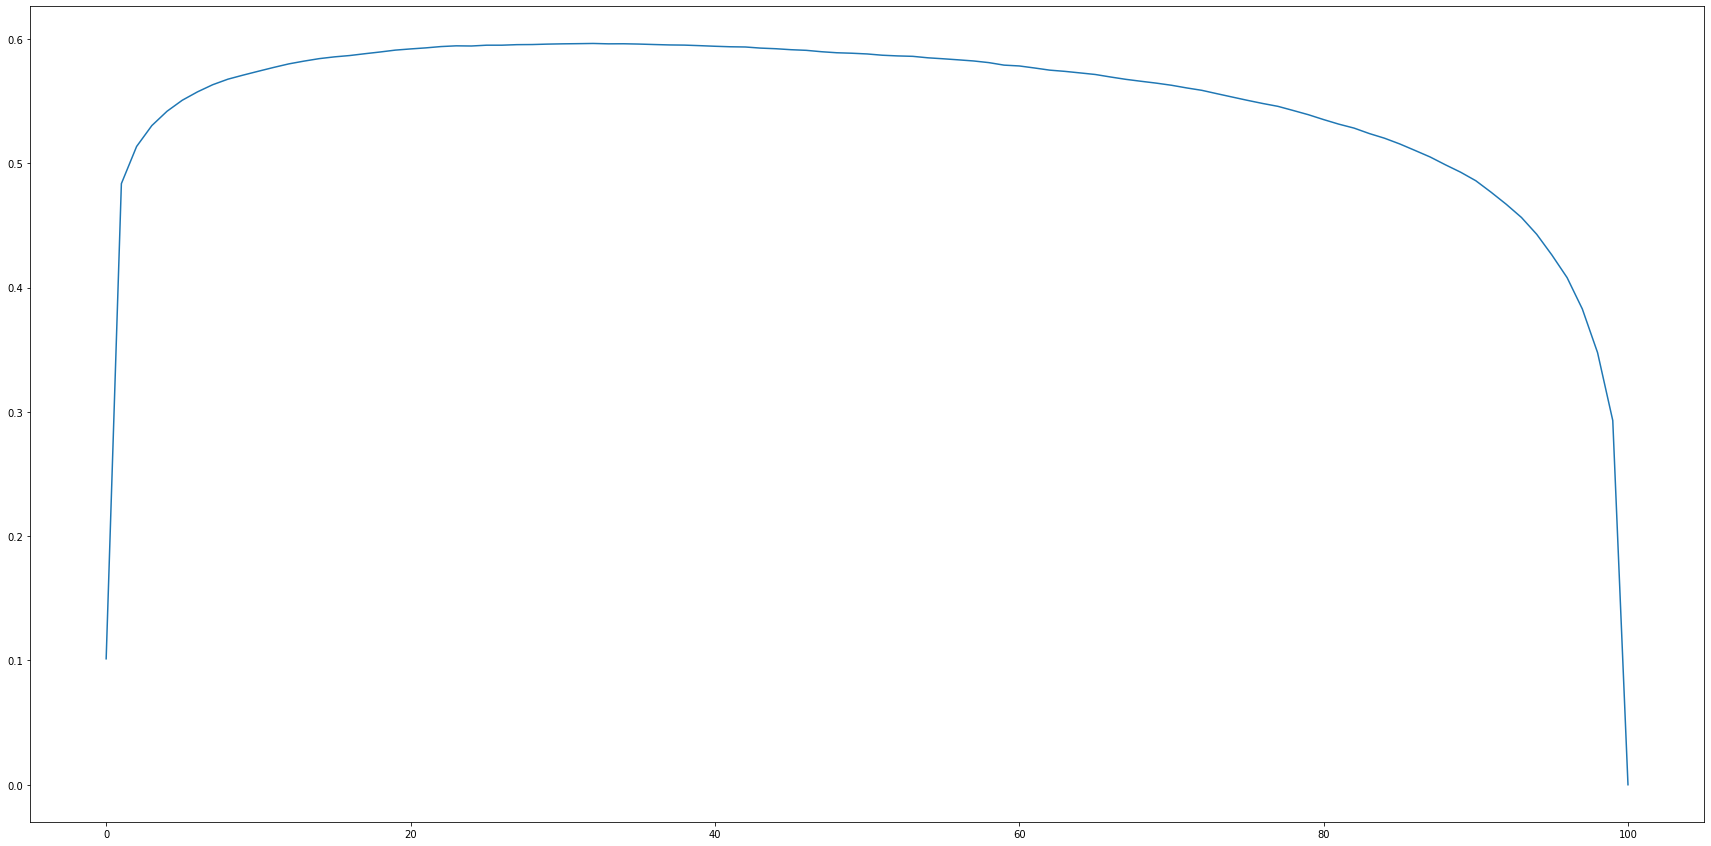

Sur le jeu test:
              precision    recall  f1-score  support
android        0.724331  0.821027  0.769654   2045.0
git            0.684385  0.751825  0.716522    274.0
python         0.664712  0.737749  0.699329   2612.0
java           0.645325  0.713884  0.677876   3558.0
php            0.621748  0.734481  0.673429   1627.0
ios            0.630551  0.702174  0.664438   1840.0
c++            0.610465  0.695010  0.650000   1964.0
javascript     0.581763  0.690107  0.631321   3356.0
css            0.577304  0.670203  0.620295   1131.0
weighted avg   0.563608  0.634729  0.596629  33044.0
micro avg      0.562456  0.634729  0.596411  33044.0
jquery         0.587937  0.602081  0.594925   1538.0
mysql          0.542821  0.629197  0.582826    685.0
c#             0.565029  0.599194  0.581610   3473.0
macro avg      0.531316  0.599282  0.562677  33044.0
html           0.496386  0.586895  0.537859   1755.0
sql            0.472727  0.537931  0.503226    870.0
node.js        0.496942  0.47

2023-01-18 20:36:06.338872: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


CPU times: user 42.1 s, sys: 3.68 s, total: 45.7 s
Wall time: 38.8 s


In [53]:
%%time
if description["USE"]["actif"]:
    X_pred_test_use = USEkerasPipeline.predict(embed(X_test.values))
    #     print(X_pred_test_use)
    best, f1_score_avg = p5_nlp_utils.Commun.find_best_limit(
        X_pred_test_use, y_test, target_names, limits=np.linspace(0, 1, 101)
    )
    pred_use_bool = p5_nlp_utils.Commun.convert_pred_to_bool(
        X_pred_test_use, limit=best
    )
    use_pred_test_score = p5_nlp_utils.Commun.save_score(
        y_true=y_test,
        y_pred=pred_use_bool,
        target_names=target_names,
        name="kerasUSE",
    )
    print("Sur le jeu test:")
    print(use_pred_test_score.sort_values(by="f1-score", ascending=False))
    USEkerasPipeline.save("kerasUSE")

La limite optimal peut etre différente en fonction des tags:

java : meilleur f1-score 67.99% pour limit 0.36
c# : meilleur f1-score 59.17% pour limit 0.19
javascript : meilleur f1-score 63.27% pour limit 0.29
python : meilleur f1-score 70.53% pour limit 0.5
android : meilleur f1-score 78.25% pour limit 0.53
c++ : meilleur f1-score 65.64% pour limit 0.41000000000000003
ios : meilleur f1-score 67.57% pour limit 0.13
html : meilleur f1-score 54.55% pour limit 0.23
php : meilleur f1-score 69.27% pour limit 0.55
.net : meilleur f1-score 36.63% pour limit 0.09
jquery : meilleur f1-score 60.14% pour limit 0.2
css : meilleur f1-score 62.64% pour limit 0.42
objective-c : meilleur f1-score 45.62% pour limit 0.1
c : meilleur f1-score 45.08% pour limit 0.26
sql : meilleur f1-score 51.02% pour limit 0.14
iphone : meilleur f1-score 44.20% pour limit 0.13
asp.net : meilleur f1-score 42.36% pour limit 0.41000000000000003
mysql : meilleur f1-score 59.37% pour limit 0.6
linux : meilleur f1-score 36.62% pour limit 0.15
node.js : meilleur f1-score 50.16% pour limit

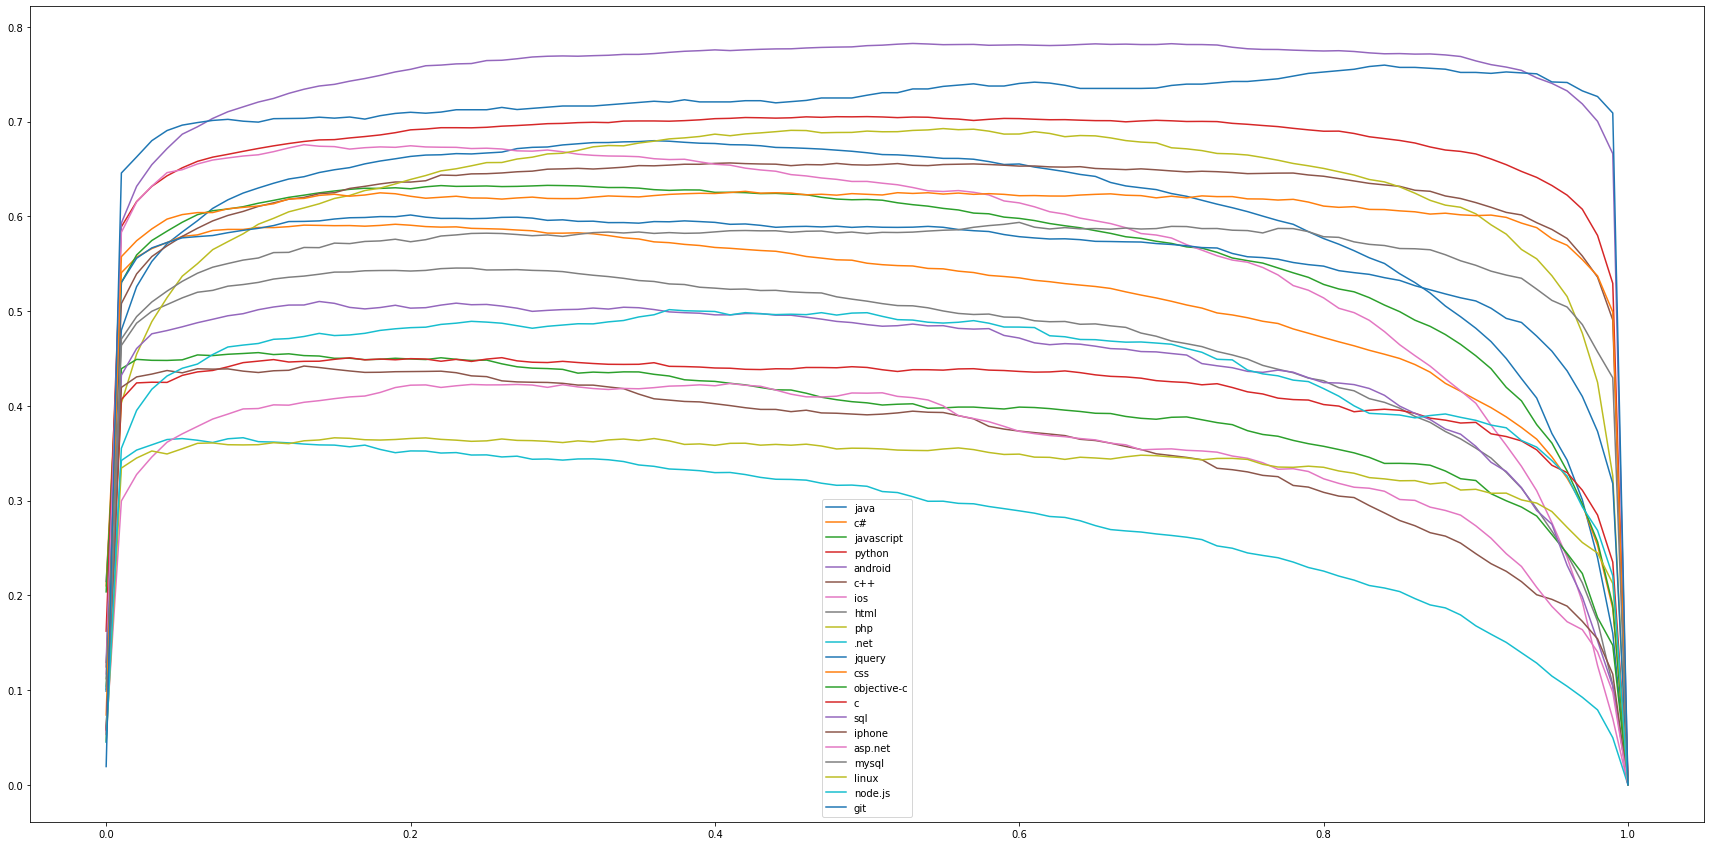

{'java': (0.36, 0.6799123047410249), 'c#': (0.19, 0.5916763303697976), 'javascript': (0.29, 0.6327350656308599), 'python': (0.5, 0.7053158705701078), 'android': (0.53, 0.7825450999512432), 'c++': (0.41000000000000003, 0.6564051638530288), 'ios': (0.13, 0.6756633119853614), 'html': (0.23, 0.5454545454545454), 'php': (0.55, 0.6927016645326505), '.net': (0.09, 0.3663323157435674), 'jquery': (0.2, 0.6014449127031908), 'css': (0.42, 0.6264343391415215), 'objective-c': (0.1, 0.45618153364632236), 'c': (0.26, 0.4508320726172466), 'sql': (0.14, 0.5101580135440181), 'iphone': (0.13, 0.44199424736337495), 'asp.net': (0.41000000000000003, 0.42358909321496513), 'mysql': (0.6, 0.5936555891238671), 'linux': (0.15, 0.36624999999999996), 'node.js': (0.37, 0.5015625), 'git': (0.84, 0.7596899224806202)}
CPU times: user 8.86 s, sys: 82.3 ms, total: 8.94 s
Wall time: 8.7 s


In [54]:
%%time
if description["USE"]["actif"]:
    best_limits_use = p5_nlp_utils.Commun.find_best_limit_by_tags(
        X_pred_test_use, y_test, target_names, limits=np.linspace(0, 1, 101)
    )
    print(best_limits_use)
    with open("/kaggle/working/best_limits_use.json", "w") as outfile:
        json.dump(best_limits_use, outfile)

In [55]:
# f1_scores = pd.DataFrame(
#     [
#         p5_nlp_utils.Commun.save_score(
#             y_true=y_test,
#             y_pred=p5_nlp_utils.Commun.convert_pred_to_bool(
#                 X_pred_test_use, limit=limit
#             ),
#             target_names=target_names,
#             name=None,
#         ).loc[target_names, "f1-score"]
#         for limit in np.linspace(0, 1, 101)
#     ],
#     index=np.linspace(0, 1, 101),
# )

In [56]:
if description["USE"]["actif"] and description["USE"]["tsne_visu"]:
    use_pred_train = USEkerasPipeline.predict(X_train_use)
    use_pred_train_bool = p5_nlp_utils.Commun.convert_pred_to_bool(
        use_pred_train, limit=best
    )
    use_pred_train_score = p5_nlp_utils.Commun.save_score(
        y_true=y_train, y_pred=use_pred_train_bool, target_names=target_names, name=None
    )
    print("Sur le jeu d'entrainement:")
    print(use_pred_train_score.sort_values(by="f1-score", ascending=False))

In [57]:
%%time
if description["USE"]["actif"] and description["USE"]["tsne_visu"]:
    X_train_use_tsne = p5_nlp_utils.Commun.calcul_tsne(X_train_use)
    print("Tag Réél:")
    p5_nlp_utils.Commun.visu_tsne(
        X_tsne=X_train_use_tsne,
        y_train_monodim=y_train_monodim,
        y_train=y_train,
        target_names=target_names,
        tag_list=[
            "java",
            "c#",
            "python",
            "android",
            "php",
            ".net",
            "mysql",
            "sql",
            "javascript",
            "jquery",
            "html",
            "node.js",
            "css",
            "c",
            "mysql",
            "linux",
            "git",
        ],
    )
    print("Tag prédit:")
    p5_nlp_utils.Commun.visu_tsne(
        X_tsne=X_train_use_tsne,
        y_train_monodim=y_train_monodim,
        y_train=use_pred_train_bool,
        target_names=target_names,
        tag_list=[
            "python",
            "java",
            "git",
            "android",
            "javascript",
            "css"
        ],
        maxcols=3,
    )

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 11.2 µs


# LDA 

In [58]:
# import importlib

# importlib.reload(p5_nlp_utils)

In [59]:
import warnings

In [60]:
%%time
lda_models = {}
if description["LDA"]["actif"]:
    print(description["LDA"])
    X_train_tokens = X_train.str.split()
    nb_num_topics = len(description["LDA"]["num_topics"])
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    for indice, num_topics in enumerate(description["LDA"]["num_topics"]):
        print(f"Début {num_topics}topics ({indice+1}/{nb_num_topics})")
        lda_model = p5_nlp_utils.LDA(
            tokens=X_train_tokens,
            num_topics=num_topics,
            no_below=description["LDA"]["lda__no_below"],
            no_above=description["LDA"]["lda__no_above"],
            max_tokens=description["LDA"]["lda__max_tokens"],
            iterations=description["LDA"]["lda__iterations"],
        )
        print(f"Nommage des topis")
        lda_model.name_topics(target_names)
        # print(lda_model.topics_names)
        lda_model.word_cloud_by_topics(
            nb_words=description["LDA"]["word_cloud__nb_words"]
        )
        lda_models[indice] = lda_model.prepare_display()

CPU times: user 9 µs, sys: 2 µs, total: 11 µs
Wall time: 15.5 µs


### Affichage des topics avec pyLDAvis:

In [61]:
pyLDAvis.display(lda_models[0].display_data) if lda_models and lda_models.get(
    0, False
) else None

In [62]:
pyLDAvis.display(lda_models[1].display_data) if lda_models and lda_models.get(
    1, False
) else None

In [63]:
pyLDAvis.display(lda_models[2].display_data) if lda_models and lda_models.get(
    2, False
) else None

In [64]:
# pyLDAvis.prepared_data_to_html(lda_models[0].display_data)

In [65]:
%%time
if description["LDA"]["actif"]:
    lda_model = lda_models[list(lda_models.keys())[-1]]  # last
    pred_lda = lda_model.predict(X_test.str.split())
    print("Exemple prediction", pred_lda[0])
    pred_lda_bool = p5_nlp_utils.LDA.convert_pred(pred_lda, target_names)
    print(pred_lda_bool.head(1))

CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 11.2 µs


In [66]:
%%time
if description["LDA"]["actif"]:
    lda_pred_test_score = p5_nlp_utils.Commun.save_score(
        y_true=y_test,
        y_pred=pred_lda_bool,
        target_names=target_names,
        name="LDA",
    )
    print("Sur le jeu test:")
    print(lda_pred_test_score.sort_values(by="f1-score", ascending=False))
    lda_model.model.save("LDA")

CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 10.5 µs


In [67]:
# X_test.values[0]

In [68]:
# pred_lda[0]

In [69]:
# y_test.iloc[0]

In [70]:
def compare_topic_tags(
    pred_topic, y_true, tags=["java", "python", "javascript", "git"]
):
    """Pour chacun des tags, regarde les topics attribué quand ce tag est présent"""
    df_pred = pd.DataFrame(pred_topic)
    for tag in tags:
        print(f"***{colors.BOLD}{tag}{colors.ENDC}*** sur {sum(y_true[tag])} positif")
        display(
            df_pred[y_true[tag].values]
            .describe()
            .sort_values(by="count", ascending=False, axis="columns")
        )
        print("\n")

In [71]:
if description["LDA"]["actif"]:
    compare_topic_tags(pred_lda, y_test)